# Assignment_7 PART-1

 Supervised Contrastive Learning - Using new loss

## Description
Create a colab demonstrating supervised contrastive learning loss based supervised classification v.s. regular softmax based one.
Be sure to provide any necessary visualizations.


In [2]:
!pip install torch torchvision scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
# Install required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15363836.63it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267598.65it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5029301.13it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 719358.91it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [5]:
# Define network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
# Train with regular softmax cross-entropy loss
def train_softmax(model, device, trainloader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    softmax_loss_list.append(epoch_loss)

## Define Supervices Contrastive Loss

In [7]:
# Define supervised contrastive loss
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        # Compute cosine similarity
        features = F.normalize(features, dim=1)
        sim = torch.div(torch.matmul(features, features.T), self.temperature)

        # Compute positive and negative pairs
        sim_pos = torch.exp(sim * mask)
        sim_neg = torch.exp(sim * (1 - mask))

        # Compute loss
        pos = torch.sum(sim_pos, dim=1) / (batch_size - 1)
        neg = torch.sum(sim_neg, dim=1) / batch_size
        loss = -torch.log(pos / (pos + neg))
        loss = torch.mean(loss)
        return loss

In [8]:
sup_con_loss = SupConLoss()

### Train function with supervised contrastive loss

In [9]:
# Train with supervised contrastive loss
def train_sup_con(model, device, trainloader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        features = model.fc1(torch.flatten(model.dropout1(F.max_pool2d(F.relu(model.conv2(F.relu(model.conv1(data)))),2)), 1))
        loss = sup_con_loss(features, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    sup_con_loss_list.append(epoch_loss)

### Evaluate Model Accuracy

In [10]:
# Evaluate model accuracy
def test(model, device, testloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(testloader.dataset)

    return accuracy

## Train and Evaluate Models

In [13]:
# Train and evaluate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_softmax = Net().to(device)
model_sup_con = Net().to(device)
optimizer_softmax = optim.Adam(model_softmax.parameters(), lr=0.001)
optimizer_sup_con = optim.Adam(model_sup_con.parameters(), lr=0.001)

num_epochs = 3
softmax_acc_list = []
sup_con_acc_list = []
softmax_loss_list = []
sup_con_loss_list = []

In [14]:
for epoch in range(1, num_epochs + 1):
    train_softmax(model_softmax, device, trainloader, optimizer_softmax, epoch)
    train_sup_con(model_sup_con, device, trainloader, optimizer_sup_con, epoch)

    softmax_acc = test(model_softmax, device, testloader)
    softmax_acc_list.append(softmax_acc)

    sup_con_acc = test(model_sup_con, device, testloader)
    sup_con_acc_list.append(sup_con_acc)

    print('Epoch: {} | Softmax Accuracy: {:.2f}% | Supervised Contrastive Accuracy: {:.2f}%'.format(epoch, softmax_acc, sup_con_acc))

Epoch: 1 | Softmax Accuracy: 88.49% | Supervised Contrastive Accuracy: 5.30%
Epoch: 2 | Softmax Accuracy: 89.99% | Supervised Contrastive Accuracy: 6.76%
Epoch: 3 | Softmax Accuracy: 91.12% | Supervised Contrastive Accuracy: 9.66%


### Visualization

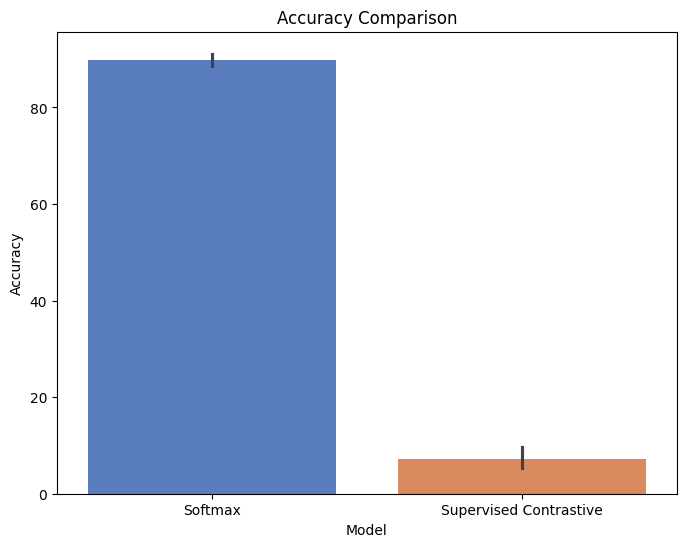

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting accuracy using a violin plot
plt.figure(figsize=(8, 6))
sns.barplot(data=[softmax_acc_list, sup_con_acc_list], palette="muted")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks([0, 1], ['Softmax', 'Supervised Contrastive'])
plt.show()


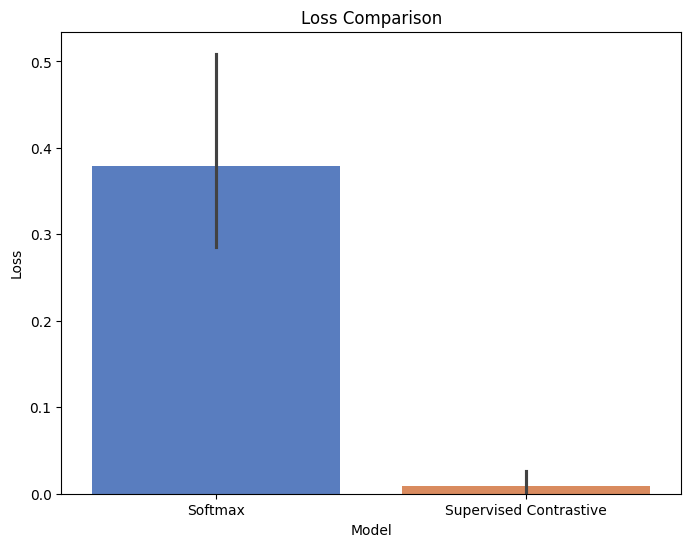

In [26]:
plt.figure(figsize=(8, 6))
sns.barplot(data=[softmax_loss_list, sup_con_loss_list], palette="muted")
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.xticks([0, 1], ['Softmax', 'Supervised Contrastive'])
plt.show()

#### Data Visualization: t-SNE

In [27]:
def plot_embeddings(model, trainloader, device, method):
    model.eval()

    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in trainloader:
            data = data.to(device)
            features = model.fc1(torch.flatten(model.dropout1(F.max_pool2d(F.relu(model.conv2(F.relu(model.conv1(data)))),2)), 1))
            embeddings.append(features.cpu().numpy())
            labels.append(target.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for i in range(10):
        inds = np.where(labels == i)[0]
        plt.scatter(embeddings_2d[inds, 0], embeddings_2d[inds, 1],
                    alpha=0.5, color=colors[i], label=str(i))
    plt.legend(fontsize='large', markerscale=2)
    plt.title('%s Embeddings' % method, fontsize=24)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


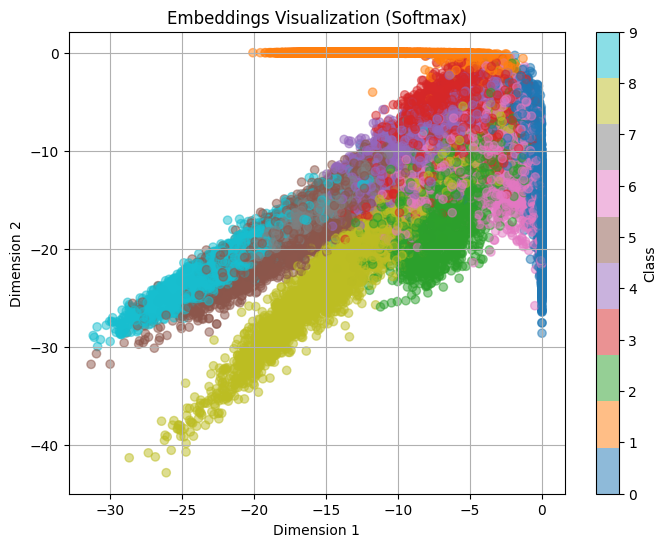

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_embeddings(model, dataloader, device, model_name):
    embeddings = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            embeddings.extend(outputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Plotting embeddings using a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(label='Class')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(f'Embeddings Visualization ({model_name})')
    plt.grid(True)
    plt.show()

# Usage:
plot_embeddings(model_softmax, trainloader, device, 'Softmax')


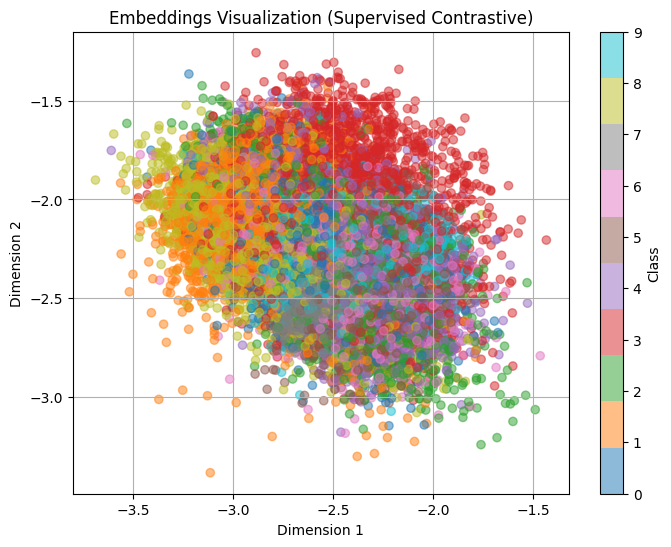

In [30]:
plot_embeddings(model_sup_con, trainloader, device, 'Supervised Contrastive')